In [1]:
import polars as pl
import yaml

from pathlib import Path

from pam import read

from nhts.trips import preprocess

In [2]:
pops = {}

with open("nhts/trips_dictionary.yaml") as f:
    config = yaml.safe_load(f)

for year, name in [
    (2022, "tripv2pub.csv"),
    (2017, "trippub.csv"),
    (2009, "DAYV2PUB.CSV"),
    (2001, "DAYPUB.csv")
    ]:
    path = Path("~/Data/foundata/NHTS") / str(year) / name
    trips = (
        pl.read_csv(path, ignore_errors=True)
    )
    trips = preprocess(trips, year=year, config=config)
    print(len(trips))
    # pam_trips = read.load_travel_diary(
    #     trips=trips.to_pandas()
    # )
    # pops[year] = pam_trips


30844
915050
1060185
472704


In [ ]:
len(trips.filter(trips["mode"] == "pl.Null"))

0

In [ ]:
root = Path("~/Data/foundata/NHTS/2022")

hhs = (
    pl.read_csv(root / "hhv2pub.csv", ignore_errors=True)
    # .fill_nan(-9)
    # .fill_null(-9)
)
persons = (
    pl.read_csv(root / "perv2pub.csv", ignore_errors=True)
)
trips = (
    pl.read_csv(root / "tripv2pub.csv", ignore_errors=True)
)
vehicles = (
    pl.read_csv(root / "vehv2pub.csv", ignore_errors=True)
)

In [ ]:
print(len(trips))
trips.head(10)

31074


HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,…,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,OBHUR,DBHUR,TRIPMODE,OTHTNRNT,OTPPOPDN,OTRESDN,OTEEMPDN,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
9000013002,1,1,1,900001300201,1,2,1,1,1,2,75,2,3,1,50,15,1435,1450,1,1,3,2,1,2,2,1,-1,-1,-1,-1,-1,-1,0,2,1,1,…,1,5,1,4,1,202202,1,1021,39,2,2,1,1,2,1,7,3,2,3,11,4,4,1,20,4,2,5,5,4,3,5,5,3,6,5,4,3
9000013002,1,2,2,900001300201,1,2,1,1,1,2,-9,2,3,15,1,10,1605,1615,1,1,3,2,1,2,2,1,-1,-1,-1,-1,-1,-1,0,2,1,1,…,1,5,1,4,1,202202,1,1021,39,2,2,1,1,2,1,7,3,2,3,11,4,4,1,5,5,3,6,5,4,3,20,4,2,5,5,4,3
9000013002,2,1,1,900001300202,1,-1,1,1,1,2,10,2,2,1,80,30,700,730,1,2,3,1,2,1,2,2,-1,-1,-1,-1,-1,-1,0,1,2,1,…,1,5,1,4,1,202202,1,1021,42,1,1,1,1,2,2,7,-1,1,3,11,4,2,1,20,4,2,5,5,4,3,40,5,4,6,60,4,3
9000013002,2,2,2,900001300202,1,-1,1,1,1,2,10,2,5,12,80,10,740,750,1,2,3,1,2,1,2,2,-1,-1,-1,-1,-1,-1,0,1,2,1,…,1,5,1,4,1,202202,1,1021,42,1,1,1,1,2,2,7,-1,1,3,11,2,2,1,40,5,4,6,60,4,3,5,3,2,4,5,3,2
9000013002,2,3,3,900001300202,1,-1,1,1,1,2,-9,2,2,12,1,30,800,830,1,2,3,1,2,1,2,2,-1,-1,-1,-1,-1,-1,0,1,2,1,…,1,5,1,4,1,202202,1,1021,42,1,1,1,1,2,2,7,-1,1,3,11,2,4,1,5,3,2,4,5,3,2,20,4,2,5,5,4,3
9000013002,4,1,1,900001300201,1,-1,1,1,1,2,75,2,3,1,50,15,1435,1450,1,1,3,2,1,2,2,1,-1,-1,-1,-1,-1,-1,0,2,1,2,…,1,5,1,4,1,202202,1,1021,5,-7,-1,-1,1,2,2,-1,-1,1,3,11,4,4,2,20,4,2,5,5,4,3,5,5,3,6,5,4,3
9000013002,4,2,2,900001300201,1,-1,1,1,1,2,-9,2,3,15,1,10,1605,1615,1,1,3,2,1,2,2,1,-1,-1,-1,-1,-1,-1,0,2,1,2,…,1,5,1,4,1,202202,1,1021,5,-7,-1,-1,1,2,2,-1,-1,1,3,11,4,4,2,5,5,3,6,5,4,3,20,4,2,5,5,4,3
9000013016,1,1,1,900001301601,1,2,1,2,4,2,260,2,4,1,30,10,930,940,1,1,1,2,1,1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,2,2,…,3,3,1,2,1,202202,2,1021,32,2,1,1,1,2,1,6,-1,2,1,7,3,3,2,80,7,3,8,90,7,6,60,6,5,8,70,6,5
9000013016,1,2,2,900001301601,1,2,1,2,4,2,105,2,5,11,40,15,1400,1415,1,1,1,2,1,1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,2,2,…,3,3,1,2,1,202202,2,1021,32,2,1,1,1,2,1,6,-1,2,1,7,3,2,2,60,6,5,8,70,6,5,80,4,2,5,30,2,-9


In [ ]:
trips = (
    pl.read_csv(root / "tripv2pub.csv", ignore_errors=True)
)



trips = trips.select(columns.keys()).rename(columns)
print(len(trips))

trips = trips.with_columns(
    (pl.col("hid").cast(pl.String) + pl.col("pid").cast(pl.String)).cast(pl.Int64).alias("pid")
)

mask = pl.any_horizontal(pl.all() == -9)
keep = trips.group_by("pid").agg(mask.any().alias("flag")).filter(~pl.col("flag")).select("pid")
trips = trips.join(keep, on="pid")

def hhmm_to_minutes(i):
    hh = i // 100
    mm = i % 100
    return hh * 60 + mm

trips = trips.with_columns(
    distance = pl.col("distance") * 1.6,
    tst = pl.col("tst").map_elements(hhmm_to_minutes),
    mode = pl.col("mode").replace_strict(mode_mapping, return_dtype=pl.String),
    oact = pl.col("oact").replace_strict(act_mapping, return_dtype=pl.String),
    dact = pl.col("dact").replace_strict(act_mapping, return_dtype=pl.String),
    ozone = 0,
    dzone = 0
)

trips = trips.with_columns(
    tet = (pl.col("tst") + pl.col("duration")),
)

trips


NameError: name 'columns' is not defined

In [ ]:
pam_population = read.load_travel_diary(
    trips=trips.to_pandas()
)

Using from-to activity parser using 'oact' and 'dact' columns

        Unable to load household area ('hzone') - not found in trips_diary or unable to build from attributes.
        Pam will try to infer home location from activities, but this behaviour is not recommended.
        
Using freq of 'None' for all trips.
 Person pid:90000132372 hid:9000013237 plan does not start with 'home' activity: visit
 Person pid:90000132682 hid:9000013268 plan does not start with 'home' activity: leisure
 Person pid:90000132683 hid:9000013268 plan does not start with 'home' activity: leisure
 Person pid:90000132684 hid:9000013268 plan does not start with 'home' activity: leisure
 Person pid:90000132871 hid:9000013287 plan does not start with 'home' activity: visit
 Person pid:90000141551 hid:9000014155 plan does not start with 'home' activity: leisure
 Person pid:90000141552 hid:9000014155 plan does not start with 'home' activity: leisure
 Person pid:90000142801 hid:9000014280 plan does not start wit

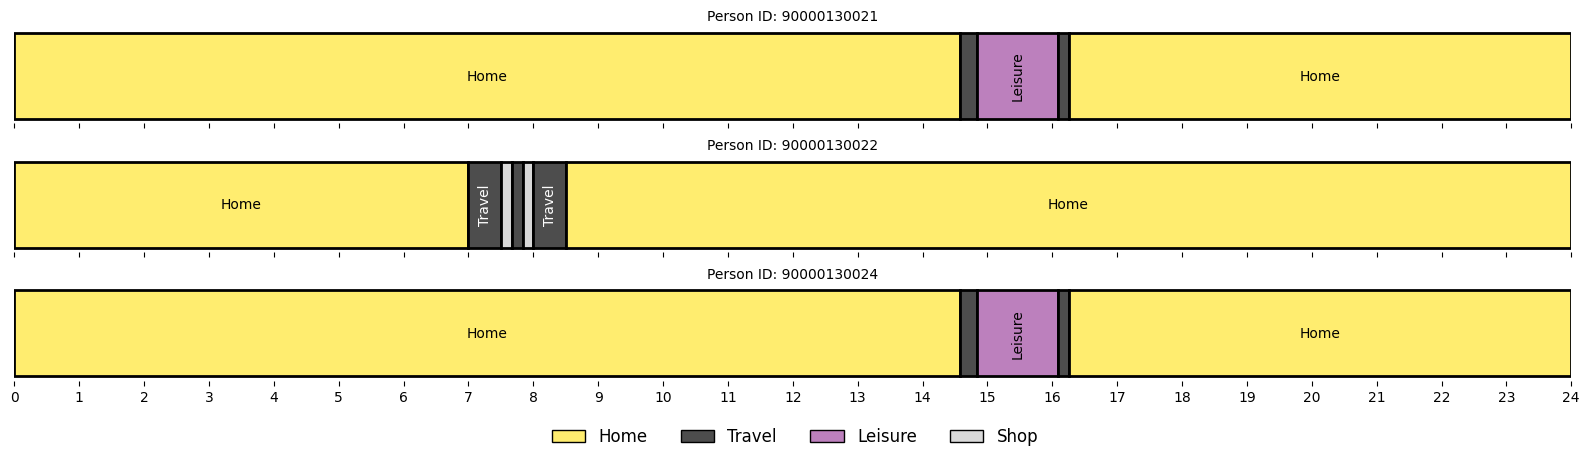

In [ ]:
pam_population[9000013002].plot()

In [ ]:
mask = trips["pid"] == 90001079021
trips.filter(mask)

hid,pid,seq,mode,distance,tst,duration,oact,dact,ozone,dzone,tet
i64,i64,i64,str,f64,i64,i64,str,str,i32,i32,i64
9000107902,90001079021,1,"""car""",27.344189,580,25,"""visit""","""medical""",0,0,605
9000107902,90001079021,2,"""car""",28.453947,735,25,"""medical""","""visit""",0,0,760
9000107902,90001079021,3,"""car""",38.65059,945,30,"""visit""","""visit""",0,0,975
9000107902,90001079021,4,"""car""",173.668117,1110,105,"""visit""","""home""",0,0,1215


In [ ]:
raw = (
    pl.read_csv(root / "tripv2pub.csv", ignore_errors=True)
)
raw.filter(raw["HOUSEID"] == 9000106833)

HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,…,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,OBHUR,DBHUR,TRIPMODE,OTHTNRNT,OTPPOPDN,OTRESDN,OTEEMPDN,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
9000106833,1,1,1,900010683302,1,2,1,1,1,2,140,2,4,1,20,40,900,940,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,1,…,1,5,1,1,1,202207,1,1030,45,1,1,1,1,1,1,4,-1,1,3,6,2,4,1,5,3,2,4,5,2,2,50,6,5,7,40,6,4
9000106833,1,2,2,900010683302,1,2,1,1,1,2,-9,2,5,19,80,45,1200,1245,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,1,…,1,5,1,1,1,202207,1,1030,45,1,1,1,1,1,1,4,-1,1,3,6,4,2,1,50,6,5,7,40,6,4,5,3,2,4,5,2,2
9000106833,2,1,1,900010683302,1,2,1,1,1,2,140,2,4,1,20,40,900,940,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,40,2,2,1,1,1,1,4,3,2,3,6,2,4,2,5,3,2,4,5,2,2,50,6,5,7,40,6,4
9000106833,2,2,2,900010683302,1,2,1,1,1,2,-9,2,5,19,80,45,1200,1245,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,40,2,2,1,1,1,1,4,3,2,3,6,4,2,2,50,6,5,7,40,6,4,5,3,2,4,5,2,2
9000106833,3,1,1,900010683302,1,-1,1,1,1,2,140,2,4,1,20,40,900,940,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,15,2,-1,2,1,1,2,2,-1,2,3,6,2,4,2,5,3,2,4,5,2,2,50,6,5,7,40,6,4
9000106833,3,2,2,900010683302,1,-1,1,1,1,2,-9,2,5,19,80,45,1200,1245,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,15,2,-1,2,1,1,2,2,-1,2,3,6,4,2,2,50,6,5,7,40,6,4,5,3,2,4,5,2,2
9000106833,4,1,1,900010683302,1,-1,1,1,1,2,140,2,4,1,20,40,900,940,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,13,1,-1,-1,1,1,2,-1,-1,1,3,6,2,4,2,5,3,2,4,5,2,2,50,6,5,7,40,6,4
9000106833,4,2,2,900010683302,1,-1,1,1,1,2,-9,2,5,19,80,45,1200,1245,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,13,1,-1,-1,1,1,2,-1,-1,1,3,6,4,2,2,50,6,5,7,40,6,4,5,3,2,4,5,2,2
9000106833,5,1,1,900010683302,1,-1,1,1,1,2,140,2,4,1,20,40,900,940,1,2,3,5,1,1,1,1,1,-1,-1,-1,-1,-1,0,5,1,2,…,1,5,1,1,1,202207,1,1030,10,1,-1,-1,1,1,2,-1,-1,1,3,6,2,4,2,5,3,2,4,5,2,2,50,6,5,7,40,6,4


In [ ]:
raw.filter(raw["HOUSEID"] == 9000106833)[["WHYFROM", "WHYTO", "WHYTRP1S", "WHYTRP90"]]

WHYFROM,WHYTO,WHYTRP1S,WHYTRP90
i64,i64,i64,i64
1,19,20,5
19,12,80,10
1,19,20,5
19,12,80,10
1,19,20,5
19,12,80,10
1,19,20,5
19,12,80,10
1,19,20,5


In [ ]:
import json

for sheet in zip(
    ["Household", "Person", "Vehicle", "Trip", "Long Distance"],
    ["hh", "person", "veh", "trip", "long"]
):
    map = pl.read_excel(root / "codebook.xlsx", sheet_name=sheet)

# for table, name in zip(
#     ["HOUSEHOLD", "PERSON", "GPS_DAY", "VEHICLE"],
#     
# ):
#     data = maps.filter(pl.col("TABLE") == table)
#     mapper = {}
#     for i, frame in data.group_by("NAME"):
#         column = str(i[0]).lower()
#         mapper[column] = {}
#         keys = frame.select(pl.col("VALUE")).rows()
#         values = frame.select(pl.col("LABEL")).rows()
#         for k, v in zip(keys, values):
#             mapper[column][int(k[0])] = str(v[0])

#     with open(f"cmap/{name}_dictionary.json", "w", encoding="utf-8") as f:
#         json.dump(mapper, f, ensure_ascii=False, indent=4)

In [ ]:
map

Name,Label,Type,Length,Code / Range,Frequency,Weighted
str,str,str,i64,str,i64,f64
"""CDIVMSAR""","""Grouping of household by combi…","""C""",2,"""11=New England MSA/CMSA of 1 m…",161,2.0662e6
"""""",null,"""""",null,"""12=New England MSA/CMSA of 1 m…",51,703523.166832
"""""",null,"""""",null,"""13=New England MSA of less tha…",208,3.1351e6
"""""",null,"""""",null,"""14=New England Not in an MSA""",19,221998.326625
"""""",null,"""""",null,"""21=Mid-Atlantic MSA/CMSA of 1 …",468,8.3308e6
…,…,…,…,…,…,…
"""YOUNGCHILD""","""Count of household members und…","""N""",8,"""0""",7271,1.1434e8
"""""",null,"""""",null,"""1""",445,9.4967e6
"""""",null,"""""",null,"""2""",154,3.2843e6


In [ ]:
hhs

HOUSEID,WTHHFIN,WTHHFIN5D,WTHHFIN2D,NUMADLT,HOMEOWN,HOMETYPE,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CNTTDHH,CDIVMSAR,FLAG100,HHFAMINC,HHFAMINC_IMP,HH_RACE,HHSIZE,HHVEHCNT,HHRELATD,LIF_CYC,MSACAT,MSASIZE,TRAVDAY,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
9000013002,4621.758002,0.0,13946.191168,2,1,1,1,1,1,2,2,7,11,1,11,11,1,4,2,1,4,1,5,1,1,4,1,2,0,4,1,202202,1,1021,4,20,4,2,5,5,4,3
9000013016,2982.998407,3878.814279,0.0,2,3,3,2,1,1,2,2,6,13,1,7,7,1,2,1,1,2,3,3,4,1,2,1,0,0,2,1,202202,2,1021,3,80,7,3,8,90,7,6
9000013026,9979.573402,14700.796695,0.0,1,3,3,1,1,1,2,1,0,11,1,10,10,1,1,0,2,1,1,5,3,1,4,1,0,0,1,1,202202,1,1021,5,60,7,6,8,70,7,3
9000013039,10355.890735,13150.678996,0.0,2,3,3,1,1,1,2,2,2,11,1,7,7,1,4,1,1,6,1,4,5,1,4,1,2,0,4,1,202201,1,1021,5,60,7,6,8,60,7,2
9000013041,4926.862529,7061.357485,0.0,1,1,2,2,1,1,2,1,0,12,1,11,11,1,1,1,2,1,2,4,2,1,3,1,0,0,1,1,202201,1,1021,4,30,5,4,6,40,6,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9000218013,8792.888034,11731.186218,0.0,2,1,1,2,6,3,2,1,3,63,1,3,3,1,2,1,1,10,3,1,5,1,1,1,0,0,2,1,202301,0,1031,2,20,4,3,4,5,3,2
9000218021,2508.248447,0.0,16373.594134,1,2,1,2,6,3,2,1,0,63,1,4,4,1,1,1,2,9,3,1,1,4,6,2,0,0,1,2,202212,0,1032,2,5,2,2,3,20,2,2
9000218034,12559.6319,17007.945486,0.0,2,2,1,2,6,3,2,2,0,64,1,4,4,1,2,2,1,10,4,6,5,4,6,2,0,0,2,2,202212,0,1032,1,5,1,1,-9,5,1,1
